In [1]:
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
import torch
from torch import nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [5]:
steel_industry_energy_consumption = fetch_ucirepo(id=851) 

In [6]:
X = steel_industry_energy_consumption.data.features 
y = steel_industry_energy_consumption.data.targets   
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include=np.number).columns

In [7]:
y = LabelEncoder().fit_transform(np.ravel(y))

columnTransformer = ColumnTransformer(
    transformers=[
        ('categorical', TargetEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)]
)
X = columnTransformer.fit_transform(X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

In [9]:
class MyDataset(Dataset):
    def __init__(self, X, y, q = 1):
        self.X = torch.tensor(X, dtype = torch.float)
        self.y = torch.tensor(y).long()
        self.q = q
    def __len__(self):
        return self.X.shape[0] - (self.q-1)
    def __getitem__(self, index):
        return (self.X[index:index+self.q], self.y[index+self.q-1])

In [10]:
train_loader = DataLoader(MyDataset(X_train, y_train, 5), batch_size = 64, shuffle = False)
test_loader = DataLoader(MyDataset(X_test, y_test, 5), batch_size = 64, shuffle = False)

In [11]:
def plot_lossacc(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

## RNN 

In [12]:
class RNN_Classifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.RNN(input_size = in_features, hidden_size = hidden_size, batch_first = True, nonlinearity='relu')
        self.classifier = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, out = self.encoder(x)
        return self.classifier(out[-1])

In [13]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [14]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
RNN_train_losses, RNN_train_accuracies = [], []
RNN_test_losses, RNN_test_accuracies = [], []
for epoch in pbar:
    RNN_train_loss, RNN_train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        RNN_train_loss += loss.item() * X_batch.shape[0]
        RNN_train_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    RNN_test_loss, RNN_test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        RNN_test_loss += loss.item() * X_batch.shape[0]
        RNN_test_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    RNN_train_loss /= len(train_loader.dataset)
    RNN_test_loss /= len(test_loader.dataset)
    RNN_train_accuracy /= len(train_loader.dataset)
    RNN_test_accuracy /= len(test_loader.dataset)
    RNN_train_losses += [RNN_train_loss]
    RNN_train_accuracies += [RNN_train_accuracy]
    RNN_test_losses += [RNN_test_loss]
    RNN_test_accuracies += [RNN_test_accuracy]
    pbar.set_postfix({'train loss': RNN_train_loss, 'test loss': RNN_test_loss, 'train accuracy' : RNN_train_accuracy, 'test accuracy' : RNN_test_accuracy})


  0%|          | 0/100 [00:00<?, ?it/s]

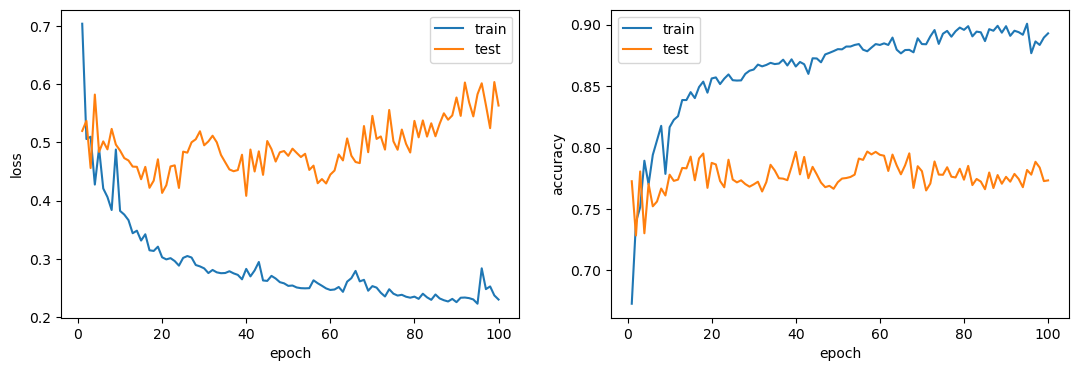

In [15]:
plot_lossacc(RNN_train_losses, RNN_test_losses, RNN_train_accuracies, RNN_test_accuracies)


In [16]:
print('train loss', RNN_train_loss)
print('test loss', RNN_test_loss)
print('train accuracy',  RNN_train_accuracy)
print('test accuracy', RNN_test_accuracy)

train loss 0.23009411568641994
test loss 0.5634939200628345
train accuracy 0.8929183323814963
test accuracy 0.7732624518338804


## LSTM 

In [17]:
class LSTM_Classifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size = in_features, hidden_size = hidden_size, batch_first = True)
        self.classifier = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, out = self.encoder(x)
        hn, cn = out
        return self.classifier(hn[-1])

In [18]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = LSTM_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [19]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
LSTM_train_losses, LSTM_train_accuracies = [], []
LSTM_test_losses, LSTM_test_accuracies = [], []
for epoch in pbar:
    LSTM_train_loss, LSTM_train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        LSTM_train_loss += loss.item() * X_batch.shape[0]
        LSTM_train_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    LSTM_test_loss, LSTM_test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        LSTM_test_loss += loss.item() * X_batch.shape[0]
        LSTM_test_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    LSTM_train_loss /= len(train_loader.dataset)
    LSTM_test_loss /= len(test_loader.dataset)
    LSTM_train_accuracy /= len(train_loader.dataset)
    LSTM_test_accuracy /= len(test_loader.dataset)
    LSTM_train_losses += [LSTM_train_loss]
    LSTM_train_accuracies += [LSTM_train_accuracy]
    LSTM_test_losses += [LSTM_test_loss]
    LSTM_test_accuracies += [LSTM_test_accuracy]
    pbar.set_postfix({'train loss': LSTM_train_loss, 'test loss': LSTM_test_loss, 'train accuracy' : LSTM_train_accuracy, 'test accuracy' : LSTM_test_accuracy})


  0%|          | 0/100 [00:00<?, ?it/s]

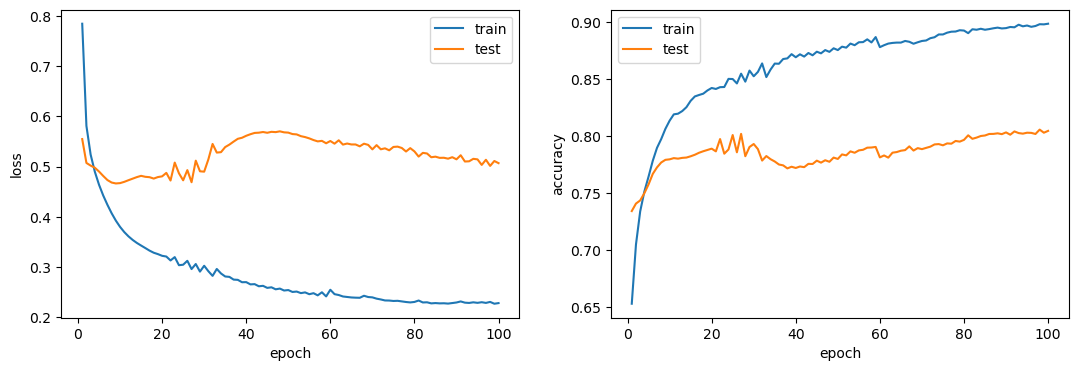

In [20]:
plot_lossacc(LSTM_train_losses, LSTM_test_losses, LSTM_train_accuracies, LSTM_test_accuracies)

In [21]:
print('train loss', LSTM_train_loss)
print('test loss', LSTM_test_loss)
print('train accuracy',  LSTM_train_accuracy)
print('test accuracy', LSTM_test_accuracy)

train loss 0.22806618757320432
test loss 0.5068562140504083
train accuracy 0.8989149057681325
test accuracy 0.8048736977308406


## GRU

In [22]:
class GRU_Classifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.GRU(input_size = in_features, hidden_size = hidden_size, batch_first = True)
        self.head = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        _, out = self.encoder(x)
        return self.head(out[-1])

In [23]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = GRU_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [24]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
GRU_train_losses, GRU_train_accuracies = [], []
GRU_test_losses, GRU_test_accuracies = [], []
for epoch in pbar:
    GRU_train_loss, GRU_train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        GRU_train_loss += loss.item() * X_batch.shape[0]
        GRU_train_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    GRU_test_loss, GRU_test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        GRU_test_loss += loss.item() * X_batch.shape[0]
        GRU_test_accuracy += np.sum(predictions.detach().numpy().argmax(axis=1) == y_batch.detach().numpy())
    GRU_train_loss /= len(train_loader.dataset)
    GRU_test_loss /= len(test_loader.dataset)
    GRU_train_accuracy /= len(train_loader.dataset)
    GRU_test_accuracy /= len(test_loader.dataset)
    GRU_train_losses += [GRU_train_loss]
    GRU_train_accuracies += [GRU_train_accuracy]
    GRU_test_losses += [GRU_test_loss]
    GRU_test_accuracies += [GRU_test_accuracy]
    pbar.set_postfix({'train loss': GRU_train_loss, 'test loss': GRU_test_loss, 'train accuracy' : GRU_train_accuracy, 'test accuracy' : GRU_test_accuracy})


  0%|          | 0/100 [00:00<?, ?it/s]

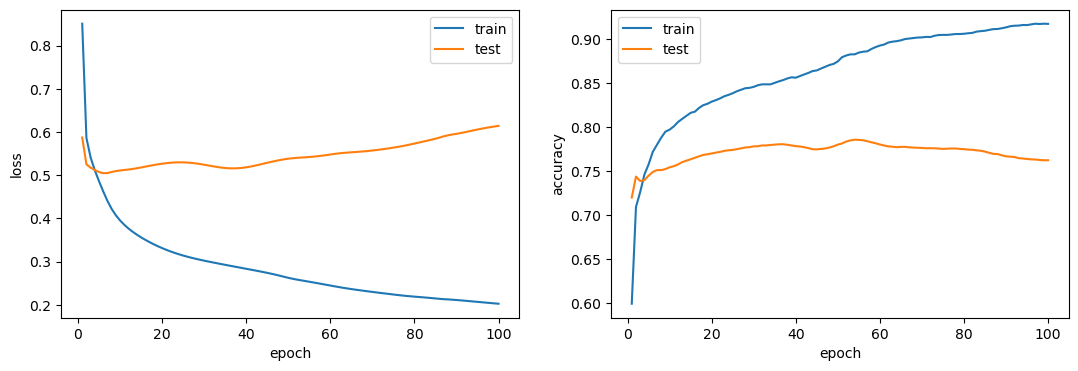

In [25]:
plot_lossacc(GRU_train_losses, GRU_test_losses, GRU_train_accuracies, GRU_test_accuracies)

In [26]:
print('train loss', GRU_train_loss)
print('test loss', GRU_test_loss)
print('train accuracy',  GRU_train_accuracy)
print('test accuracy', GRU_test_accuracy)

train loss 0.20247994690520774
test loss 0.6143240218122019
train accuracy 0.9177612792689891
test accuracy 0.762594548308834


## Сравнение моделей

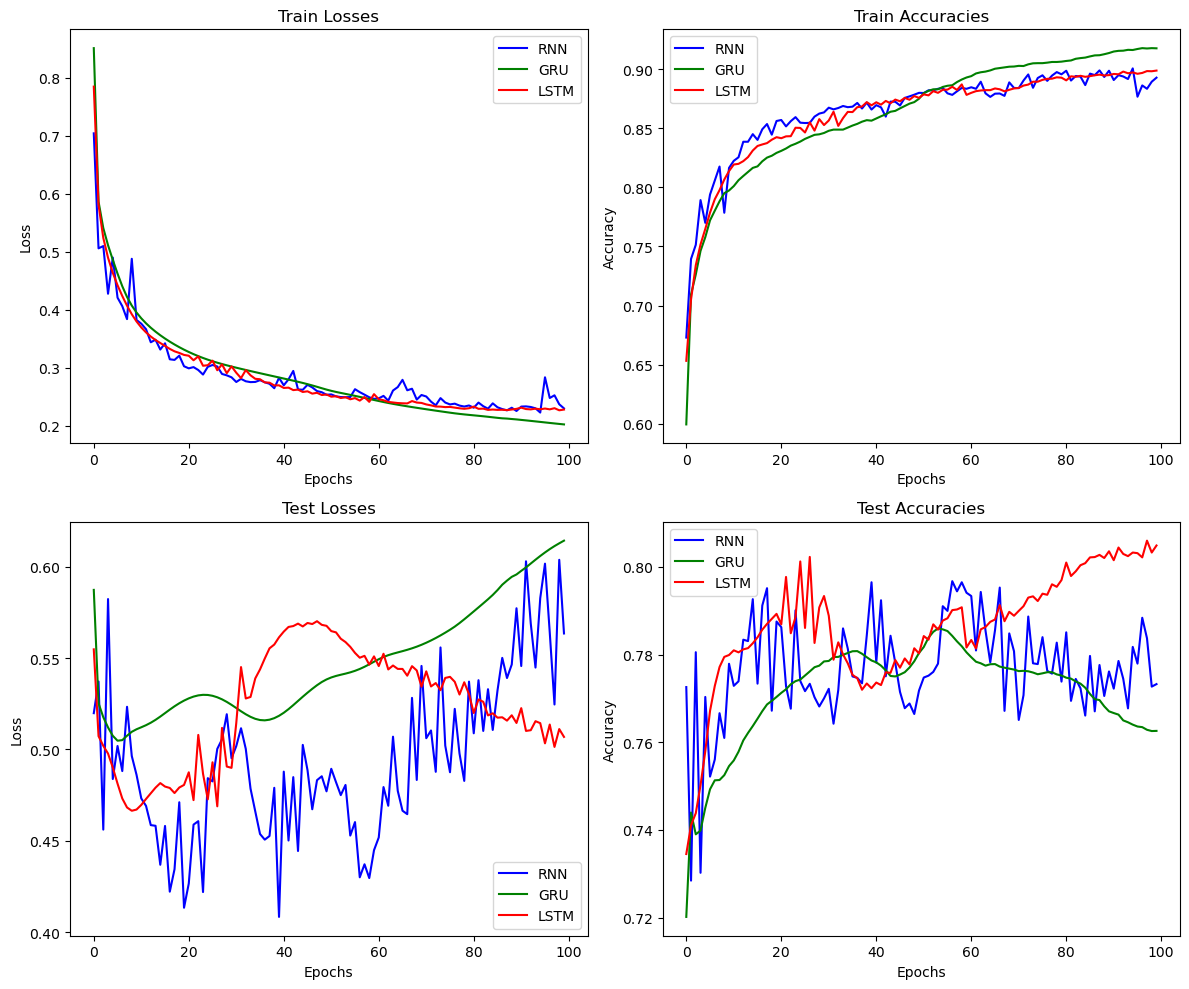

In [27]:
# Prepare figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot train losses
axes[0, 0].plot(RNN_train_losses, label='RNN', color='blue')
axes[0, 0].plot(GRU_train_losses, label='GRU', color='green')
axes[0, 0].plot(LSTM_train_losses, label='LSTM', color='red')
axes[0, 0].set_title('Train Losses')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot train accuracies
axes[0, 1].plot(RNN_train_accuracies, label='RNN', color='blue')
axes[0, 1].plot(GRU_train_accuracies, label='GRU', color='green')
axes[0, 1].plot(LSTM_train_accuracies, label='LSTM', color='red')
axes[0, 1].set_title('Train Accuracies')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot test losses
axes[1, 0].plot(RNN_test_losses, label='RNN', color='blue')
axes[1, 0].plot(GRU_test_losses, label='GRU', color='green')
axes[1, 0].plot(LSTM_test_losses, label='LSTM', color='red')
axes[1, 0].set_title('Test Losses')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Plot test accuracies
axes[1, 1].plot(RNN_test_accuracies, label='RNN', color='blue')
axes[1, 1].plot(GRU_test_accuracies, label='GRU', color='green')
axes[1, 1].plot(LSTM_test_accuracies, label='LSTM', color='red')
axes[1, 1].set_title('Test Accuracies')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()